<a href="https://colab.research.google.com/github/soulsharp/Attentive-Segnet/blob/main/Attentive_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import math
import random
import seaborn as sns

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Config dictionary** contains the configuration parameters for training and constructing the model

In [130]:
config = {

    "embed_dim":64,
    "patch_size":32,
    "in_channels":3,
    "weight_bce": 0.01,
    "weight_dice": 0.99,
    "epsilon_loss_fn": 1e6,
    "train_batch_size": 32,
    "train_epochs": 50,
    "lr": 1e-4,
    "ckpt_name": 'att_segnet.pth',
    "model_save_path":"/content/saved_models"

}

**CrackDataset** derived from torch.utils.data.Dataset contains logic to load the dataset from certain directories and apply transformations/ augmentations to it, if provided




In [131]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Custom Concrete Failure Detection(Crack) dataset

        Args:
            image_dir (str): Path to the directory containing RGB images.
            mask_dir (str): Path to the directory containing mask images.
            transform (callable, optional): A function/transform to apply to both images and masks.
        """
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.png', '.jpeg'))])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(('.jpg', '.png', '.jpeg'))])

        if len(self.image_paths) != len(self.mask_paths):
            raise ValueError("Number of images and masks must be the same!")

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Loads image and mask
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv.imread(image_path)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        if mask is None:
            raise ValueError(f"Failed to load mask: {mask_path}")

        # Applies transformations
        if self.transform:
            image, mask = self.transform(image, mask)

        # Convert to tensors
        image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.as_tensor(mask, dtype=torch.float32)

        return image, mask

# Simple preprocessing function
def transform_image_and_mask(image, mask, size=512):
    # Resize image and mask
    image = cv.resize(image, (size, size), interpolation=cv.INTER_NEAREST)
    mask = cv.resize(mask, (size, size), interpolation=cv.INTER_NEAREST)
    mask = mask/255.0
    return image, mask

This function creates the train data loader and the validation data loader from given image directories using the CrackDataset class

In [132]:
def make_train_val_loaders(image_directory, mask_directory):
  # Instantiates dataset
  dataset = CrackDataset(image_dir=image_directory, mask_dir=mask_directory, transform=transform_image_and_mask)

  # Train-validation split
  train_ratio = 0.8
  train_size = int(len(dataset) * train_ratio)
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  # Creates DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

  return train_loader, val_loader

**Patch_Embedding**

This class derived from nn.Module forms a core transformation included in the Attentive Segnet model.It takes an image batch of shape **(Batch_size, channels, height, width)** and divides the input images into equal sized patches resulting in a tensor of the shape **(Batch_size, num_patches, embed_dim)**.

Each patch contains encoded information about a section of the image

In [133]:
# Encodes patch representation of an image batch
class Patch_Embedding(nn.Module):
    def __init__(self, embed_dim=64, patch_size=32, in_channels=3):
        super(Patch_Embedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.convolution = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Expects x to be of shape (batch_size, channels, height, width)
        h, w = x.shape[2], x.shape[3]
        if h % self.patch_size != 0 or w % self.patch_size != 0:
          raise ValueError("Input dimensions must be divisible by the patch size.")
        # Applies convolution to create patches
        patches = self.convolution(x)

        return patches

In [134]:
# returns a tensor after applying maxpool2d
# also returns the indices used up in the max pool
class MaxPoolWithIndices(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MaxPoolWithIndices, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.maxpool = nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride, return_indices=True)

    def forward(self, x):
        output, indices = self.maxpool(x)
        return output, indices

In [135]:
# basic convblock with conv2d-->batchnorm-->relu-->maxpool(optional)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, maxpool_flag=True):
        super(ConvBlock, self).__init__()
        self.maxpool_flag = maxpool_flag
        self.operation_seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        if self.maxpool_flag:
            self.maxpool = MaxPoolWithIndices(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.operation_seq(x)

        if self.maxpool_flag:
            pooled, indices = self.maxpool(x)
            return pooled, indices
        else:
            return x, None

In [136]:
class Downsample(nn.Module):
    def __init__(self):
        super(Downsample, self).__init__()

        # Initializes the conv blocks
        self.conv_blocks = nn.ModuleList([
            ConvBlock(3, 8, 3, 1, 1),
            ConvBlock(8, 16, 3, 1, 1),
            ConvBlock(16, 32, 3, 1, 1),
            ConvBlock(32, 64, 3, 4, 1, False)  # block4 (no maxpool)
        ])

    def forward(self, input_tensor):
        max_indices = {}
        bottleneck_input = None

        # Ensures that input dimensions are divisible by 4
        assert input_tensor.shape[-2] % 4 == 0 and input_tensor.shape[-1] % 4 == 0, \
            "Input dimensions must be divisible by 4 for this downsampling pipeline."

        # Goes through all blocks in conv blocks sequentially
        for idx, conv_block in enumerate(self.conv_blocks):
            input_tensor, indices = conv_block(input_tensor)

            # Saves max indices for each block
            block_name = f"block{idx + 1}"

            # The last block ie block4 gives the output to be used as bottleneck
            if block_name == "block4":
                bottleneck_input = input_tensor
            else:
                max_indices[block_name] = indices

        return max_indices, bottleneck_input

In [137]:
# Attention weights to scale the patch embed representation
class AttentionWeights(nn.Module):
    def __init__(self, output_dim):
        super(AttentionWeights, self).__init__()
        self.alphas = nn.Parameter(torch.randn(output_dim))
        self.layer_norm = nn.LayerNorm([256, 64])

    def forward(self, patch_emb_tensor):

        # adding a dimension ie making alphas (256, 1) for proper broadcasting
        scaled_input = self.alphas.unsqueeze(1) * patch_emb_tensor

        # Normalizes input for stability
        normalized_scaled_input = self.layer_norm(scaled_input)

        return normalized_scaled_input


In [138]:
# Takes in the bottleneck tensor and adds patch embeddings to it
def add_bottleneck_and_patch_embeddings(bottleneck, patch_embedding):

  num_batches, num_channels, h, w = bottleneck.shape
  patch_embedding = patch_embedding.permute(0, 2, 1)
  patch_embedding = patch_embedding.view(num_batches, num_channels, h, w)

  return bottleneck + patch_embedding

In [139]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(UpBlock, self).__init__()
        self.operation_sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.operation_sequence(x)
        return output

In [140]:
class Unpool2d(nn.Module):
  def __init__(self, k_sz, stride):
    super(Unpool2d, self).__init__()
    self.unpool2d = nn.MaxUnpool2d(k_sz, stride)

  def forward(self, pooled, indices):
    return self.unpool2d(pooled, indices)

In [141]:
class Upsample(nn.Module):
    def __init__(self):
        super(Upsample, self).__init__()

        # Defines the sequence of UpBlocks and Unpool2d layers
        self.up_blocks = nn.ModuleList([
            UpBlock(64, 32, kernel_size=4, stride=4, padding=0),
            Unpool2d(2, 2),
            UpBlock(32, 16, kernel_size=3, stride=1, padding=1),
            Unpool2d(2, 2),
            UpBlock(16, 8, kernel_size=3, stride=1, padding=1),
            Unpool2d(2, 2),
            UpBlock(8, 1, kernel_size=3, stride=1, padding=1),
        ])

    def forward(self, input_tensor, max_indices):
        count = 0
        for idx, layer in enumerate(self.up_blocks):

            # Upblock layer
            if idx % 2 == 0:
                input_tensor = layer(input_tensor)

            # Unpool layer
            else:
                max_index_key = "block" + str(3 - count)
                input_tensor = layer(input_tensor, max_indices[max_index_key])
                count += 1
        return input_tensor

In [142]:
class weightedBCEDiceLoss(nn.Module):
  def __init__(self, weight_BCE, weight_Dice, epsilon):
    super(weightedBCEDiceLoss, self).__init__()
    self.alpha = weight_BCE
    self.beta = weight_Dice
    self.eps = epsilon
    assert math.isclose(self.alpha + self.beta, 1.0, rel_tol=1e-6), "Weights of BCE and Dice Loss must sum to 1"

  def forward(self, preds, targets):
    preds = preds.view(-1)
    targets = targets.view(-1)
    print(f"Shape of prds is {preds.shape}, shape of targets is {targets.shape}")

    bce_criterion = nn.BCELoss()
    bce_loss = bce_criterion(preds, targets)

    intersection = torch.sum(preds * targets)
    union = torch.sum(preds) + torch.sum(targets)
    dice_coeff = (2 * intersection + self.eps) / (union + self.eps)
    dice_loss = 1 - dice_coeff

    total_loss = self.alpha * bce_loss + self.beta * dice_loss

    return total_loss


In [143]:
class AttentiveSegnet(nn.Module):
  def __init__(self, config):
    super(AttentiveSegnet, self).__init__()
    self.patch_embedding = Patch_Embedding(config["embed_dim"], config["patch_size"], config["in_channels"])
    self.downsample_block = Downsample()
    self.upsample_block = Upsample()
    self.attention_weights = AttentionWeights(256)
    self.embed_dim = config['embed_dim']
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Computes patch encodings for the input tensor x and scales the representations
    patched_encodings = self.patch_embedding(x)
    patched_encodings = patched_encodings.view(patched_encodings.size(0), -1, self.embed_dim)
    attention_dim = patched_encodings.size(1)

    # # Dynamically initialize attention weights if not already initialized
    # if self.attention_weights is None:
    #   self.attention_weights = AttentionWeights(attention_dim)
    #   self.add_module("Attention_weights", self.attention_weights)

    # self.attention_weights = self.attention_weights.to(patched_encodings.device)

    scaled_embeddings = self.attention_weights(patched_encodings)

    # Downsample, combine embeddings and upscale
    max_indices, bottleneck_input = self.downsample_block(x)

    print(f"Max val of bneck input is {torch.max(bottleneck_input)}, Min val of bneck input is {torch.min(bottleneck_input)}")

    bottleneck_plus_emb = add_bottleneck_and_patch_embeddings(bottleneck_input, scaled_embeddings)

    print(f"Max val of bottleneck_plus_emb {torch.max(bottleneck_plus_emb)}, Min val of bneckplusemb is {torch.min(bottleneck_plus_emb)}")
    output_mask = self.upsample_block(bottleneck_plus_emb, max_indices)

    # Debugging
    print(f"Max val before sigmoid is {torch.max(output_mask)}, Min val before sigmoid is {torch.min(output_mask)}")
    output_mask = self.sigmoid(output_mask)

    return output_mask


In [144]:
def train_for_one_epoch(epoch_idx, model, train_loader, optimizer, config):

    r"""
    Method to run the training for one epoch.
    :param epoch_idx: iteration number of current epoch
    :param model: Attentive SegNet model
    :param train_loader: Dataloader for the training set
    :param optimizer: optimizer to be used
    :param config: config dictionary that contains model information
    :return: loss value for the epoch
    """

    losses = []
    criterion = weightedBCEDiceLoss(config["weight_bce"], config["weight_dice"], config["epsilon_loss_fn"])

    # Iterates through the dataloader in form of batches
    for batch in tqdm(train_loader):
        im, mask = batch
        im = im.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        model_output = model(im)
        loss = criterion(model_output, mask)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Prints epoch and loss info
    print('Finished epoch: {} | Number Loss : {:.4f}'.
          format(epoch_idx + 1,
                 np.mean(losses)))
    return np.mean(losses)

def train(train_loader, config):
    model = AttentiveSegnet(config).to(device)
    num_epochs = config['train_epochs']
    optimizer = Adam(model.parameters(), lr=config['lr'])
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

    # Creates output directories
    if not os.path.exists(config['model_save_path']):
        os.mkdir(config['model_save_path'])

    # Loads checkpoint if found
    if os.path.exists(os.path.join(config['model_save_path'], config['ckpt_name'])):
        print('Loading checkpoint')
        model.load_state_dict(torch.load(os.path.join(config['model_save_path'],
                                    config['ckpt_name']), map_location=device))
    best_loss = np.inf

    for epoch_idx in range(num_epochs):
        mean_loss = train_for_one_epoch(epoch_idx, model, train_loader, optimizer, config)
        scheduler.step(mean_loss)

        # Updates checkpoint if better model params found
        if mean_loss < best_loss:
            print('Improved Loss to {:.4f} .... Saving Model'.format(mean_loss))
            torch.save(model.state_dict(), os.path.join(config['model_save_path'],
                                            config['ckpt_name']))
            best_loss = mean_loss
        else:
            print('No Loss Improvement')

In [145]:
def get_segmentation_accuracy(preds, targets):
  preds = preds.view(-1)
  targets = targets.view(-1)

  matches = (preds == targets).sum().item()
  accuracy = matches / preds.size(0)
  return accuracy

def post_process(preds):
  result = torch.where(preds>0.505, 255.0 , 0.0)
  return result

def visualize_preds(preds, masks):
   fig, axes = plt.subplots(4, 2, figsize=(10, 20))

   for i in range(4):
      axes[i, 0].imshow(masks[i].squeeze(1).cpu().detach().numpy(), cmap='gray')
      axes[i, 0].set_title(f"Ground Truth {i+1}")
      axes[i, 0].axis('off')

      axes[i, 1].imshow(preds[i].squeeze().cpu().detach().numpy(), cmap='gray')
      axes[i, 1].set_title(f"Prediction {i+1}")
      axes[i, 1].axis('off')

   plt.tight_layout()
   plt.show()


def inference(val_loader, config):
   model = AttentiveSegnet(config).to(device)
   model.eval()

   # Loads checkpoint if found
   if os.path.exists(os.path.join(config['model_save_path'], config['ckpt_name'])):
        print('Loading checkpoint')
        model.load_state_dict(torch.load(os.path.join(config['model_save_path'],
                                     config['ckpt_name']), map_location=device))
   else:
        print('No checkpoint found at {}'.format(os.path.join(config['model_save_path'],
                                        config['ckpt_name'])))

   for idx, batch in enumerate(tqdm(val_loader)):
        im, mask = batch
        im = im.to(device)
        mask = mask.to(device)
        preds = model(im)
        preds = preds.to(device)

        preds = post_process(preds)

        # Randomly picks any 4 images of the 1st batch for viz
        if idx == 0:
            random_indices = random.sample(range(im.size(0)), 4)
            selected_images = im[random_indices]
            selected_preds = preds[random_indices]
            selected_masks = mask[random_indices]
            visualize_preds(selected_preds, selected_masks)

            print(torch.max(selected_preds), torch.min(selected_preds))

            sns.histplot(selected_preds.cpu().detach().numpy().flatten(), bins=255)
            plt.title("Distribution of Selected Predictions")
            plt.xlabel("Prediction Values")
            plt.ylabel("Frequency")
            plt.show()



        accuracy = get_segmentation_accuracy(preds, mask)
        print(f"Accuracy in batch {idx} during validation is: {accuracy:.4f}")

In [146]:
image_directory = "/content/images"
mask_directory = "/content/masks"
train_loader, val_loader = make_train_val_loaders(image_directory, mask_directory)

In [147]:
model = AttentiveSegnet(config).to(device)
print(type(model.parameters()))

<class 'generator'>


In [148]:
for param in model.parameters():
    print(param.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [149]:
for name, param in model.named_parameters():
    print(name, param.size(), param.device)

patch_embedding.convolution.weight torch.Size([64, 3, 32, 32]) cuda:0
patch_embedding.convolution.bias torch.Size([64]) cuda:0
downsample_block.conv_blocks.0.operation_seq.0.weight torch.Size([8, 3, 3, 3]) cuda:0
downsample_block.conv_blocks.0.operation_seq.0.bias torch.Size([8]) cuda:0
downsample_block.conv_blocks.0.operation_seq.1.weight torch.Size([8]) cuda:0
downsample_block.conv_blocks.0.operation_seq.1.bias torch.Size([8]) cuda:0
downsample_block.conv_blocks.1.operation_seq.0.weight torch.Size([16, 8, 3, 3]) cuda:0
downsample_block.conv_blocks.1.operation_seq.0.bias torch.Size([16]) cuda:0
downsample_block.conv_blocks.1.operation_seq.1.weight torch.Size([16]) cuda:0
downsample_block.conv_blocks.1.operation_seq.1.bias torch.Size([16]) cuda:0
downsample_block.conv_blocks.2.operation_seq.0.weight torch.Size([32, 16, 3, 3]) cuda:0
downsample_block.conv_blocks.2.operation_seq.0.bias torch.Size([32]) cuda:0
downsample_block.conv_blocks.2.operation_seq.1.weight torch.Size([32]) cuda:0
d

In [150]:
train(train_loader, config)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-144-6bec21f05579>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of 

Loading checkpoint


 33%|███▎      | 1/3 [00:00<00:01,  1.25it/s]

Max val of bneck input is 11.092195510864258, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.111560821533203, Min val of bneckplusemb is -10.262385368347168
Max val before sigmoid is 80.35240173339844, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.03it/s]

Max val of bneck input is 14.386489868164062, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.5235538482666, Min val of bneckplusemb is -8.550742149353027
Max val before sigmoid is 104.44290161132812, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Max val of bneck input is 14.403583526611328, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.761363983154297, Min val of bneckplusemb is -8.287068367004395
Max val before sigmoid is 70.64561462402344, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 1 | Number Loss : 0.7807
Improved Loss to 0.7807 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

Max val of bneck input is 12.221141815185547, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.0655517578125, Min val of bneckplusemb is -10.262893676757812
Max val before sigmoid is 78.21542358398438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.24it/s]

Max val of bneck input is 12.48653793334961, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.76534652709961, Min val of bneckplusemb is -8.671154975891113
Max val before sigmoid is 100.74642944335938, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Max val of bneck input is 14.249249458312988, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.427297592163086, Min val of bneckplusemb is -7.489139556884766
Max val before sigmoid is 80.03614807128906, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 2 | Number Loss : 0.7806
Improved Loss to 0.7806 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]

Max val of bneck input is 13.202081680297852, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.005931854248047, Min val of bneckplusemb is -8.46653938293457
Max val before sigmoid is 93.17179107666016, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 14.615917205810547, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.585739135742188, Min val of bneckplusemb is -10.251321792602539
Max val before sigmoid is 93.2017593383789, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Max val of bneck input is 13.014328002929688, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 18.4781494140625, Min val of bneckplusemb is -7.988594055175781
Max val before sigmoid is 85.30677032470703, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 3 | Number Loss : 0.7805
Improved Loss to 0.7805 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 13.511102676391602, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.96884536743164, Min val of bneckplusemb is -7.577698230743408
Max val before sigmoid is 79.7278060913086, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.34it/s]

Max val of bneck input is 12.925346374511719, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.6673583984375, Min val of bneckplusemb is -10.249646186828613
Max val before sigmoid is 83.7433090209961, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Max val of bneck input is 12.689359664916992, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.567699432373047, Min val of bneckplusemb is -8.26898193359375
Max val before sigmoid is 97.51263427734375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 4 | Number Loss : 0.7805
Improved Loss to 0.7805 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

Max val of bneck input is 14.140060424804688, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.02324676513672, Min val of bneckplusemb is -7.994504928588867
Max val before sigmoid is 98.5389404296875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.25it/s]

Max val of bneck input is 13.111387252807617, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.590415954589844, Min val of bneckplusemb is -8.70511531829834
Max val before sigmoid is 83.01678466796875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Max val of bneck input is 13.43867301940918, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.639808654785156, Min val of bneckplusemb is -10.260828971862793
Max val before sigmoid is 84.62032318115234, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 5 | Number Loss : 0.7805
Improved Loss to 0.7805 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

Max val of bneck input is 14.350688934326172, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.32888412475586, Min val of bneckplusemb is -8.228883743286133
Max val before sigmoid is 77.5950927734375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.01it/s]

Max val of bneck input is 13.45949649810791, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.180919647216797, Min val of bneckplusemb is -8.75365161895752
Max val before sigmoid is 92.20361328125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Max val of bneck input is 12.980612754821777, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.646678924560547, Min val of bneckplusemb is -10.266342163085938
Max val before sigmoid is 78.16111755371094, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 6 | Number Loss : 0.7804
Improved Loss to 0.7804 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

Max val of bneck input is 13.755626678466797, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.102088928222656, Min val of bneckplusemb is -8.660595893859863
Max val before sigmoid is 83.81566619873047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

Max val of bneck input is 13.416959762573242, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.029626846313477, Min val of bneckplusemb is -10.268082618713379
Max val before sigmoid is 100.53056335449219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Max val of bneck input is 15.08765697479248, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.66498565673828, Min val of bneckplusemb is -7.586195945739746
Max val before sigmoid is 95.87847900390625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 7 | Number Loss : 0.7804
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

Max val of bneck input is 13.200176239013672, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.969514846801758, Min val of bneckplusemb is -8.743946075439453
Max val before sigmoid is 77.25147247314453, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.87it/s]

Max val of bneck input is 14.327218055725098, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.88500213623047, Min val of bneckplusemb is -7.5862226486206055
Max val before sigmoid is 94.35943603515625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Max val of bneck input is 14.424973487854004, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.923181533813477, Min val of bneckplusemb is -10.272004127502441
Max val before sigmoid is 96.74803161621094, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 8 | Number Loss : 0.7803
Improved Loss to 0.7803 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 14.248839378356934, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.972415924072266, Min val of bneckplusemb is -7.505903720855713
Max val before sigmoid is 93.91783905029297, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 13.303443908691406, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.785938262939453, Min val of bneckplusemb is -10.274325370788574
Max val before sigmoid is 84.7364273071289, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 14.27019214630127, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.153703689575195, Min val of bneckplusemb is -8.775917053222656
Max val before sigmoid is 78.15129852294922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 9 | Number Loss : 0.7803
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 13.300588607788086, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.01691246032715, Min val of bneckplusemb is -10.276844024658203
Max val before sigmoid is 81.13822174072266, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 13.830168724060059, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.868379592895508, Min val of bneckplusemb is -8.774599075317383
Max val before sigmoid is 92.75233459472656, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 13.887747764587402, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.765552520751953, Min val of bneckplusemb is -8.654212951660156
Max val before sigmoid is 85.92649841308594, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 10 | Number Loss : 0.7803
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 15.458720207214355, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.862356185913086, Min val of bneckplusemb is -8.773107528686523
Max val before sigmoid is 102.23163604736328, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 13.959288597106934, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.35483169555664, Min val of bneckplusemb is -8.261311531066895
Max val before sigmoid is 107.19891357421875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 12.791288375854492, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.921356201171875, Min val of bneckplusemb is -10.284392356872559
Max val before sigmoid is 78.35910034179688, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 11 | Number Loss : 0.7801
Improved Loss to 0.7801 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 13.176770210266113, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.480552673339844, Min val of bneckplusemb is -8.770798683166504
Max val before sigmoid is 84.63567352294922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]

Max val of bneck input is 15.17874526977539, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.5341796875, Min val of bneckplusemb is -8.652693748474121
Max val before sigmoid is 102.81866455078125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Max val of bneck input is 13.973206520080566, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.770614624023438, Min val of bneckplusemb is -10.288471221923828
Max val before sigmoid is 93.31307983398438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 12 | Number Loss : 0.7801
Improved Loss to 0.7801 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 13.621848106384277, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.565767288208008, Min val of bneckplusemb is -10.289767265319824
Max val before sigmoid is 70.87258911132812, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 13.371689796447754, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.415342330932617, Min val of bneckplusemb is -8.766884803771973
Max val before sigmoid is 87.3006591796875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 14.978851318359375, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.59579849243164, Min val of bneckplusemb is -8.255680084228516
Max val before sigmoid is 106.31875610351562, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 13 | Number Loss : 0.7800
Improved Loss to 0.7800 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 15.254124641418457, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.909461975097656, Min val of bneckplusemb is -8.765165328979492
Max val before sigmoid is 97.61949157714844, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.28it/s]

Max val of bneck input is 15.833979606628418, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.890735626220703, Min val of bneckplusemb is -10.294957160949707
Max val before sigmoid is 95.84455871582031, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 12.573784828186035, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.381423950195312, Min val of bneckplusemb is -8.631526947021484
Max val before sigmoid is 82.38916015625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 14 | Number Loss : 0.7800
Improved Loss to 0.7800 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 14.30634880065918, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.24565887451172, Min val of bneckplusemb is -10.298123359680176
Max val before sigmoid is 85.87667846679688, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 14.788158416748047, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.18170166015625, Min val of bneckplusemb is -8.761627197265625
Max val before sigmoid is 89.75201416015625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Max val of bneck input is 14.039173126220703, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.820053100585938, Min val of bneckplusemb is -8.646544456481934
Max val before sigmoid is 77.39032745361328, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 15 | Number Loss : 0.7798
Improved Loss to 0.7798 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]

Max val of bneck input is 15.375940322875977, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.72787094116211, Min val of bneckplusemb is -8.759960174560547
Max val before sigmoid is 89.15959167480469, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

Max val of bneck input is 14.581977844238281, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.35498809814453, Min val of bneckplusemb is -8.64538860321045
Max val before sigmoid is 84.52763366699219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


Max val of bneck input is 13.131087303161621, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.75927734375, Min val of bneckplusemb is -10.307140350341797
Max val before sigmoid is 102.05371856689453, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 16 | Number Loss : 0.7798
Improved Loss to 0.7798 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.19s/it]

Max val of bneck input is 14.137551307678223, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.28763198852539, Min val of bneckplusemb is -10.309139251708984
Max val before sigmoid is 93.0555419921875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.52it/s]

Max val of bneck input is 12.461590766906738, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.53433609008789, Min val of bneckplusemb is -8.643878936767578
Max val before sigmoid is 85.72256469726562, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Max val of bneck input is 15.351338386535645, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.25662612915039, Min val of bneckplusemb is -8.110503196716309
Max val before sigmoid is 103.87095642089844, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 17 | Number Loss : 0.7798
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

Max val of bneck input is 13.320008277893066, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.822673797607422, Min val of bneckplusemb is -8.755850791931152
Max val before sigmoid is 103.92945861816406, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.09it/s]

Max val of bneck input is 12.696949005126953, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.947675704956055, Min val of bneckplusemb is -10.317983627319336
Max val before sigmoid is 90.5010986328125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Max val of bneck input is 16.125944137573242, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.932594299316406, Min val of bneckplusemb is -8.648285865783691
Max val before sigmoid is 79.67278289794922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 18 | Number Loss : 0.7796
Improved Loss to 0.7796 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.41it/s]

Max val of bneck input is 13.627779960632324, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.598182678222656, Min val of bneckplusemb is -10.322428703308105
Max val before sigmoid is 85.0231704711914, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 13.827430725097656, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.295185089111328, Min val of bneckplusemb is -8.753631591796875
Max val before sigmoid is 97.53592681884766, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 16.692975997924805, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 25.330713272094727, Min val of bneckplusemb is -8.653219223022461
Max val before sigmoid is 82.806884765625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 19 | Number Loss : 0.7795
Improved Loss to 0.7795 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 14.811182022094727, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.148639678955078, Min val of bneckplusemb is -10.328978538513184
Max val before sigmoid is 67.81204986572266, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 13.283556938171387, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.551692962646484, Min val of bneckplusemb is -8.656963348388672
Max val before sigmoid is 85.82160186767578, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Max val of bneck input is 14.23132038116455, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.391002655029297, Min val of bneckplusemb is -8.750646591186523
Max val before sigmoid is 92.6297836303711, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 20 | Number Loss : 0.7794
Improved Loss to 0.7794 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.42it/s]

Max val of bneck input is 13.24850082397461, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.26774024963379, Min val of bneckplusemb is -8.391040802001953
Max val before sigmoid is 90.87744140625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.35it/s]

Max val of bneck input is 15.185051918029785, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.621191024780273, Min val of bneckplusemb is -10.33846378326416
Max val before sigmoid is 89.02239227294922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Max val of bneck input is 14.867414474487305, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.59426498413086, Min val of bneckplusemb is -8.238697052001953
Max val before sigmoid is 95.3248519897461, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 21 | Number Loss : 0.7793
Improved Loss to 0.7793 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.31it/s]

Max val of bneck input is 13.806793212890625, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.913549423217773, Min val of bneckplusemb is -8.747923851013184
Max val before sigmoid is 80.39169311523438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.17it/s]

Max val of bneck input is 16.275732040405273, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.685508728027344, Min val of bneckplusemb is -8.139567375183105
Max val before sigmoid is 78.4544448852539, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Max val of bneck input is 14.40347671508789, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 25.090898513793945, Min val of bneckplusemb is -10.348682403564453
Max val before sigmoid is 98.787841796875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 22 | Number Loss : 0.7792
Improved Loss to 0.7792 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 14.158272743225098, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.160533905029297, Min val of bneckplusemb is -8.514092445373535
Max val before sigmoid is 78.90576934814453, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 15.062515258789062, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.197654724121094, Min val of bneckplusemb is -8.675835609436035
Max val before sigmoid is 90.97991943359375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Max val of bneck input is 13.377043724060059, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.971210479736328, Min val of bneckplusemb is -10.353962898254395
Max val before sigmoid is 96.6539306640625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 23 | Number Loss : 0.7791
Improved Loss to 0.7791 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.42it/s]

Max val of bneck input is 14.042313575744629, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.450889587402344, Min val of bneckplusemb is -7.438765525817871
Max val before sigmoid is 79.4305648803711, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

Max val of bneck input is 13.65941047668457, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.115379333496094, Min val of bneckplusemb is -10.356000900268555
Max val before sigmoid is 98.47308349609375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Max val of bneck input is 14.975214004516602, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.39945411682129, Min val of bneckplusemb is -8.74060344696045
Max val before sigmoid is 79.95332336425781, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 24 | Number Loss : 0.7789
Improved Loss to 0.7789 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 14.266438484191895, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.67197036743164, Min val of bneckplusemb is -8.681639671325684
Max val before sigmoid is 84.4678726196289, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 16.119260787963867, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.928699493408203, Min val of bneckplusemb is -8.227132797241211
Max val before sigmoid is 78.96939849853516, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Max val of bneck input is 13.565347671508789, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.30247688293457, Min val of bneckplusemb is -10.357994079589844
Max val before sigmoid is 83.05793762207031, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 25 | Number Loss : 0.7789
Improved Loss to 0.7789 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

Max val of bneck input is 12.80894947052002, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.603734970092773, Min val of bneckplusemb is -8.224125862121582
Max val before sigmoid is 96.27608489990234, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.54it/s]

Max val of bneck input is 16.874860763549805, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.729019165039062, Min val of bneckplusemb is -8.083227157592773
Max val before sigmoid is 96.30681610107422, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


Max val of bneck input is 13.822503089904785, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.680862426757812, Min val of bneckplusemb is -10.356863975524902
Max val before sigmoid is 95.5196533203125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 26 | Number Loss : 0.7788
Improved Loss to 0.7788 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

Max val of bneck input is 13.290266036987305, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.127700805664062, Min val of bneckplusemb is -10.356423377990723
Max val before sigmoid is 96.03276824951172, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

Max val of bneck input is 14.762831687927246, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.5751953125, Min val of bneckplusemb is -8.685526847839355
Max val before sigmoid is 81.64004516601562, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Max val of bneck input is 15.490375518798828, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 19.90792465209961, Min val of bneckplusemb is -8.223700523376465
Max val before sigmoid is 87.86729431152344, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 27 | Number Loss : 0.7787
Improved Loss to 0.7787 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

Max val of bneck input is 16.18327522277832, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.53537940979004, Min val of bneckplusemb is -7.523952484130859
Max val before sigmoid is 81.8573989868164, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

Max val of bneck input is 14.42394733428955, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.76758575439453, Min val of bneckplusemb is -8.724506378173828
Max val before sigmoid is 99.38993835449219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 12.06471061706543, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.538442611694336, Min val of bneckplusemb is -10.35464096069336
Max val before sigmoid is 85.63700866699219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 28 | Number Loss : 0.7786
Improved Loss to 0.7786 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 14.854493141174316, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.125408172607422, Min val of bneckplusemb is -10.354220390319824
Max val before sigmoid is 81.89513397216797, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 13.422971725463867, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.690814971923828, Min val of bneckplusemb is -8.720176696777344
Max val before sigmoid is 96.96599578857422, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 12.82483196258545, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.310523986816406, Min val of bneckplusemb is -8.691452026367188
Max val before sigmoid is 97.14659881591797, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 29 | Number Loss : 0.7786
Improved Loss to 0.7786 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.35it/s]

Max val of bneck input is 15.910841941833496, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.480010986328125, Min val of bneckplusemb is -8.717195510864258
Max val before sigmoid is 98.31481170654297, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 13.309271812438965, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.32292938232422, Min val of bneckplusemb is -10.352283477783203
Max val before sigmoid is 76.78002166748047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Max val of bneck input is 12.486611366271973, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.017009735107422, Min val of bneckplusemb is -8.227712631225586
Max val before sigmoid is 79.60357666015625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 30 | Number Loss : 0.7784
Improved Loss to 0.7784 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

Max val of bneck input is 14.21082878112793, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.784687042236328, Min val of bneckplusemb is -8.712044715881348
Max val before sigmoid is 83.3165283203125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 15.711277961730957, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.25353240966797, Min val of bneckplusemb is -8.294889450073242
Max val before sigmoid is 92.02119445800781, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Max val of bneck input is 12.315756797790527, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.37674331665039, Min val of bneckplusemb is -10.349630355834961
Max val before sigmoid is 79.76054382324219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 31 | Number Loss : 0.7783
Improved Loss to 0.7783 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 15.65206527709961, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.61009407043457, Min val of bneckplusemb is -8.707212448120117
Max val before sigmoid is 84.37501525878906, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Max val of bneck input is 13.092181205749512, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.372520446777344, Min val of bneckplusemb is -8.421518325805664
Max val before sigmoid is 79.87056732177734, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Max val of bneck input is 12.874523162841797, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.095006942749023, Min val of bneckplusemb is -10.347312927246094
Max val before sigmoid is 109.47010040283203, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 32 | Number Loss : 0.7781
Improved Loss to 0.7781 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 14.522704124450684, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.162975311279297, Min val of bneckplusemb is -8.703144073486328
Max val before sigmoid is 83.42101287841797, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 12.187026023864746, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.833087921142578, Min val of bneckplusemb is -10.34579849243164
Max val before sigmoid is 89.41344451904297, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 14.486629486083984, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.168066024780273, Min val of bneckplusemb is -8.231851577758789
Max val before sigmoid is 80.64005279541016, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 33 | Number Loss : 0.7781
Improved Loss to 0.7781 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 12.479625701904297, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.132888793945312, Min val of bneckplusemb is -10.34404182434082
Max val before sigmoid is 84.58745574951172, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

Max val of bneck input is 15.698188781738281, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.122482299804688, Min val of bneckplusemb is -8.687108039855957
Max val before sigmoid is 90.17034912109375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 13.08999252319336, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.55170440673828, Min val of bneckplusemb is -8.697343826293945
Max val before sigmoid is 82.07730102539062, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 34 | Number Loss : 0.7779
Improved Loss to 0.7779 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

Max val of bneck input is 14.238574981689453, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.887981414794922, Min val of bneckplusemb is -8.686277389526367
Max val before sigmoid is 81.13312530517578, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.81it/s]

Max val of bneck input is 13.822802543640137, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.043123245239258, Min val of bneckplusemb is -8.696284294128418
Max val before sigmoid is 83.73731994628906, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Max val of bneck input is 11.61507797241211, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.187938690185547, Min val of bneckplusemb is -10.338626861572266
Max val before sigmoid is 87.77548217773438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 35 | Number Loss : 0.7779
Improved Loss to 0.7779 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.09s/it]

Max val of bneck input is 12.294299125671387, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.694421768188477, Min val of bneckplusemb is -8.69585132598877
Max val before sigmoid is 88.43233489990234, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

Max val of bneck input is 13.713641166687012, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.860923767089844, Min val of bneckplusemb is -10.336882591247559
Max val before sigmoid is 80.15518188476562, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Max val of bneck input is 15.17572021484375, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.202922821044922, Min val of bneckplusemb is -7.561426162719727
Max val before sigmoid is 87.42010498046875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 36 | Number Loss : 0.7778
Improved Loss to 0.7778 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

Max val of bneck input is 12.983236312866211, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.1428279876709, Min val of bneckplusemb is -8.695836067199707
Max val before sigmoid is 85.638427734375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.96it/s]

Max val of bneck input is 13.933113098144531, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.416492462158203, Min val of bneckplusemb is -8.684488296508789
Max val before sigmoid is 78.95994567871094, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Max val of bneck input is 11.78426456451416, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.560928344726562, Min val of bneckplusemb is -10.3338041305542
Max val before sigmoid is 86.45068359375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 37 | Number Loss : 0.7777
Improved Loss to 0.7777 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

Max val of bneck input is 12.046368598937988, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 20.2774715423584, Min val of bneckplusemb is -8.684237480163574
Max val before sigmoid is 83.0954360961914, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.27it/s]

Max val of bneck input is 11.777043342590332, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.904027938842773, Min val of bneckplusemb is -10.331871032714844
Max val before sigmoid is 79.44147491455078, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Max val of bneck input is 12.800703048706055, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.476001739501953, Min val of bneckplusemb is -8.695268630981445
Max val before sigmoid is 77.7021484375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 38 | Number Loss : 0.7777
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

Max val of bneck input is 14.629084587097168, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.013797760009766, Min val of bneckplusemb is -8.694742202758789
Max val before sigmoid is 104.12323760986328, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.28it/s]

Max val of bneck input is 11.348020553588867, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.08277702331543, Min val of bneckplusemb is -8.383959770202637
Max val before sigmoid is 82.26242065429688, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Max val of bneck input is 10.868836402893066, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.244029998779297, Min val of bneckplusemb is -10.328770637512207
Max val before sigmoid is 90.45317840576172, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 39 | Number Loss : 0.7775
Improved Loss to 0.7775 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 14.225366592407227, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.026090621948242, Min val of bneckplusemb is -10.327743530273438
Max val before sigmoid is 87.64436340332031, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.31it/s]

Max val of bneck input is 11.750704765319824, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.036951065063477, Min val of bneckplusemb is -8.237542152404785
Max val before sigmoid is 78.22660827636719, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Max val of bneck input is 13.067374229431152, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.658748626708984, Min val of bneckplusemb is -8.431697845458984
Max val before sigmoid is 78.49374389648438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 40 | Number Loss : 0.7774
Improved Loss to 0.7774 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

Max val of bneck input is 12.976068496704102, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.69693946838379, Min val of bneckplusemb is -10.324413299560547
Max val before sigmoid is 84.55022430419922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.93it/s]

Max val of bneck input is 14.122603416442871, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.814117431640625, Min val of bneckplusemb is -8.678970336914062
Max val before sigmoid is 105.6439208984375, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Max val of bneck input is 12.398160934448242, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.455196380615234, Min val of bneckplusemb is -8.688472747802734
Max val before sigmoid is 88.53964233398438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 41 | Number Loss : 0.7773
Improved Loss to 0.7773 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.11s/it]

Max val of bneck input is 13.625428199768066, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.46474838256836, Min val of bneckplusemb is -8.687800407409668
Max val before sigmoid is 83.97896575927734, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]

Max val of bneck input is 12.82274055480957, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.178226470947266, Min val of bneckplusemb is -10.321468353271484
Max val before sigmoid is 72.5047607421875, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Max val of bneck input is 11.056114196777344, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.799732208251953, Min val of bneckplusemb is -7.854664325714111
Max val before sigmoid is 81.9181900024414, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 42 | Number Loss : 0.7773
Improved Loss to 0.7773 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

Max val of bneck input is 13.385334968566895, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.215675354003906, Min val of bneckplusemb is -8.686322212219238
Max val before sigmoid is 84.84003448486328, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.12it/s]

Max val of bneck input is 12.679131507873535, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.949167251586914, Min val of bneckplusemb is -10.3197603225708
Max val before sigmoid is 100.9811782836914, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Max val of bneck input is 12.601602554321289, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.561717987060547, Min val of bneckplusemb is -8.67726993560791
Max val before sigmoid is 77.09538269042969, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 43 | Number Loss : 0.7772
Improved Loss to 0.7772 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

Max val of bneck input is 12.820191383361816, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.239559173583984, Min val of bneckplusemb is -10.318288803100586
Max val before sigmoid is 92.18902587890625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  2.02it/s]

Max val of bneck input is 12.7671480178833, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.944683074951172, Min val of bneckplusemb is -8.683677673339844
Max val before sigmoid is 85.7795639038086, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Max val of bneck input is 13.330536842346191, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.67446517944336, Min val of bneckplusemb is -7.852346420288086
Max val before sigmoid is 74.91205596923828, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 44 | Number Loss : 0.7770
Improved Loss to 0.7770 .... Saving Model


 33%|███▎      | 1/3 [00:01<00:02,  1.21s/it]

Max val of bneck input is 12.135969161987305, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.10721206665039, Min val of bneckplusemb is -10.315218925476074
Max val before sigmoid is 84.28099822998047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]

Max val of bneck input is 12.423507690429688, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.296173095703125, Min val of bneckplusemb is -8.673291206359863
Max val before sigmoid is 76.24639129638672, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


Max val of bneck input is 12.415526390075684, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.07716178894043, Min val of bneckplusemb is -7.849418640136719
Max val before sigmoid is 85.55408477783203, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 45 | Number Loss : 0.7771
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

Max val of bneck input is 11.405714988708496, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.347692489624023, Min val of bneckplusemb is -10.31212329864502
Max val before sigmoid is 78.5195541381836, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:01<00:00,  1.92it/s]

Max val of bneck input is 12.15194034576416, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.25533676147461, Min val of bneckplusemb is -8.678155899047852
Max val before sigmoid is 85.02536010742188, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Max val of bneck input is 14.270853042602539, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 24.211299896240234, Min val of bneckplusemb is -7.550850868225098
Max val before sigmoid is 81.77890014648438, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 46 | Number Loss : 0.7771
No Loss Improvement


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 13.294922828674316, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.844680786132812, Min val of bneckplusemb is -8.676728248596191
Max val before sigmoid is 77.68893432617188, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

Max val of bneck input is 12.205738067626953, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.181533813476562, Min val of bneckplusemb is -10.310385704040527
Max val before sigmoid is 66.384765625, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Max val of bneck input is 10.913375854492188, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.90174102783203, Min val of bneckplusemb is -8.242955207824707
Max val before sigmoid is 92.20746612548828, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 47 | Number Loss : 0.7768
Improved Loss to 0.7768 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.35it/s]

Max val of bneck input is 13.167895317077637, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.405832290649414, Min val of bneckplusemb is -10.309409141540527
Max val before sigmoid is 79.92120361328125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.26it/s]

Max val of bneck input is 11.565543174743652, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.221193313598633, Min val of bneckplusemb is -7.529654026031494
Max val before sigmoid is 81.60425567626953, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Max val of bneck input is 11.684276580810547, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.306713104248047, Min val of bneckplusemb is -8.30921459197998
Max val before sigmoid is 99.05870819091797, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 48 | Number Loss : 0.7767
Improved Loss to 0.7767 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.30it/s]

Max val of bneck input is 12.865022659301758, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.339393615722656, Min val of bneckplusemb is -8.672016143798828
Max val before sigmoid is 79.31379699707031, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.22it/s]

Max val of bneck input is 13.423465728759766, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.632766723632812, Min val of bneckplusemb is -8.242402076721191
Max val before sigmoid is 79.51146697998047, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Max val of bneck input is 11.509889602661133, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 21.472667694091797, Min val of bneckplusemb is -10.306392669677734
Max val before sigmoid is 94.44071960449219, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 49 | Number Loss : 0.7767
Improved Loss to 0.7767 .... Saving Model


 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

Max val of bneck input is 11.919848442077637, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.85675811767578, Min val of bneckplusemb is -8.665884971618652
Max val before sigmoid is 96.24424743652344, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


 67%|██████▋   | 2/3 [00:00<00:00,  2.32it/s]

Max val of bneck input is 14.444830894470215, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 23.52615737915039, Min val of bneckplusemb is -10.304494857788086
Max val before sigmoid is 76.198486328125, Min val before sigmoid is 0.0
Shape of prds is torch.Size([8388608]), shape of targets is torch.Size([8388608])


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

Max val of bneck input is 10.933095932006836, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 22.083293914794922, Min val of bneckplusemb is -7.531848907470703
Max val before sigmoid is 76.34954071044922, Min val before sigmoid is 0.0
Shape of prds is torch.Size([7602176]), shape of targets is torch.Size([7602176])
Finished epoch: 50 | Number Loss : 0.7766
Improved Loss to 0.7766 .... Saving Model


Loading checkpoint


<ipython-input-145-fc74384e2360>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config['model_save_path'],
  0%|          | 

Max val of bneck input is 12.248838424682617, Min val of bneck input is 0.0
Max val of bottleneck_plus_emb 26.12390899658203, Min val of bneckplusemb is -7.649423599243164
Max val before sigmoid is 72.0317611694336, Min val before sigmoid is 0.0


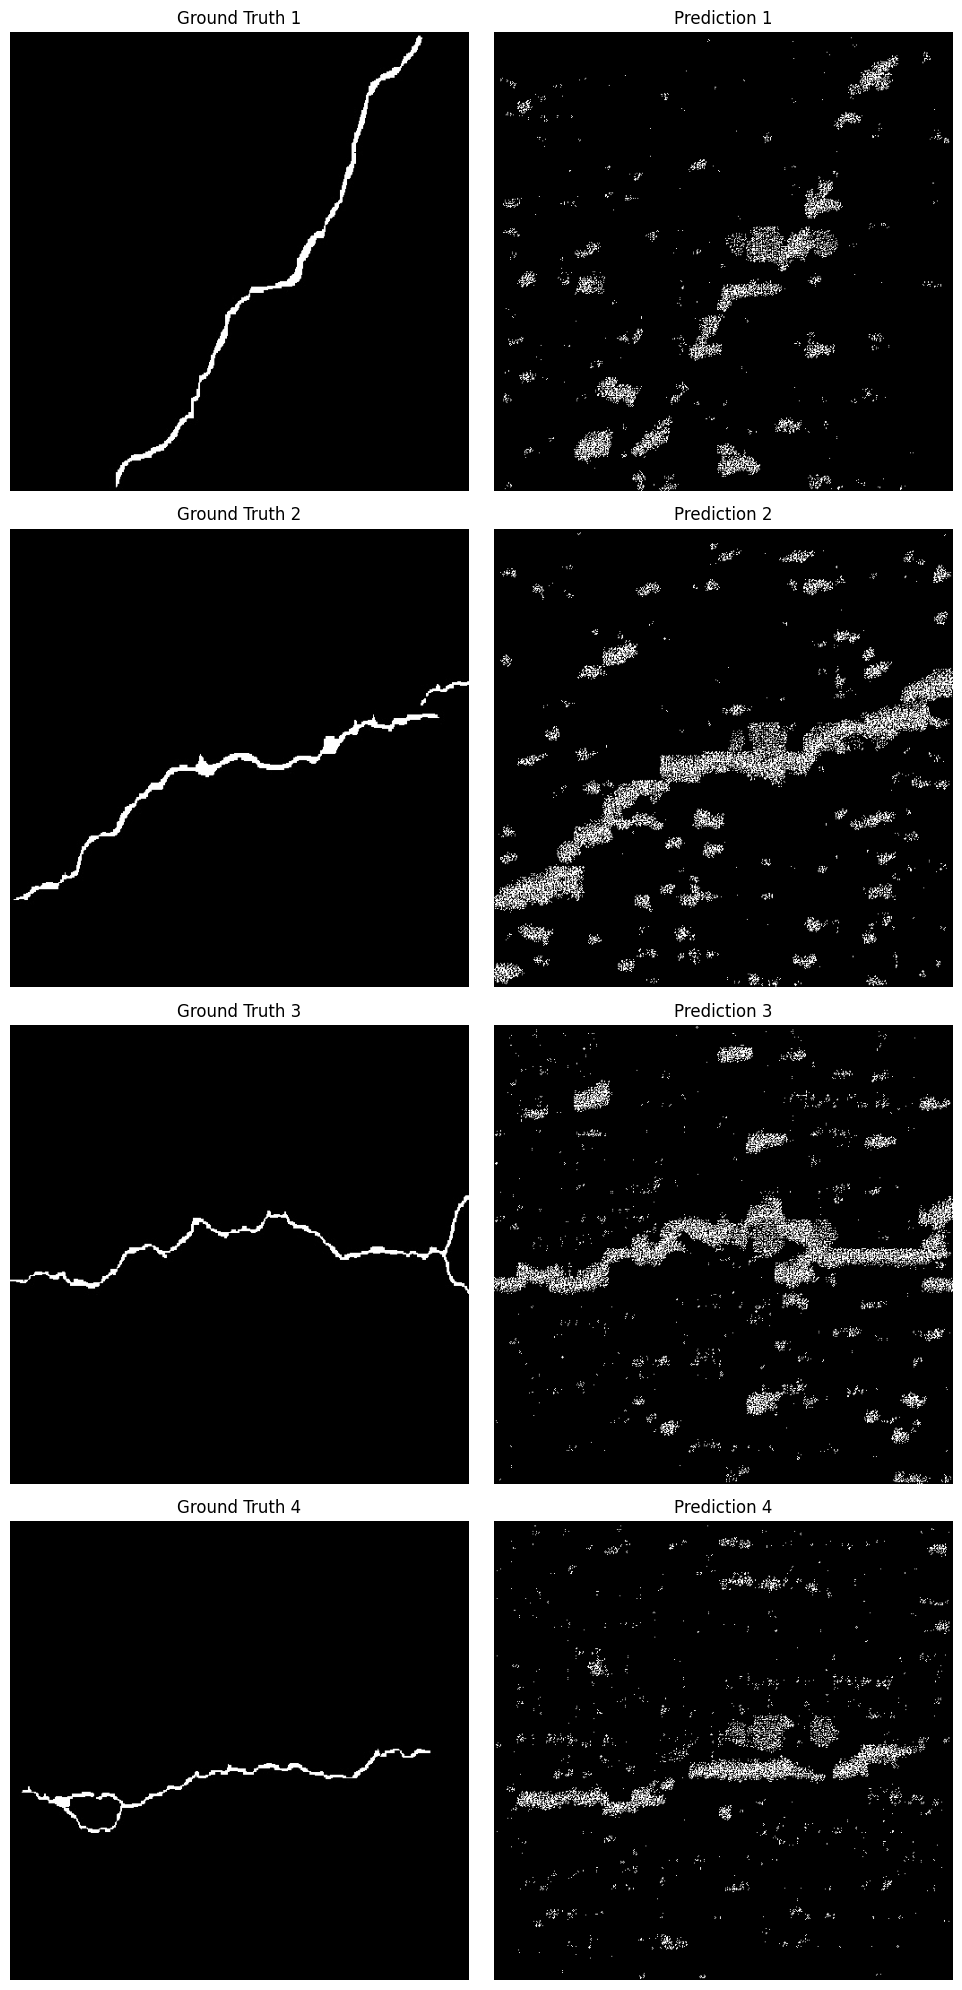

tensor(255., device='cuda:0') tensor(0., device='cuda:0')


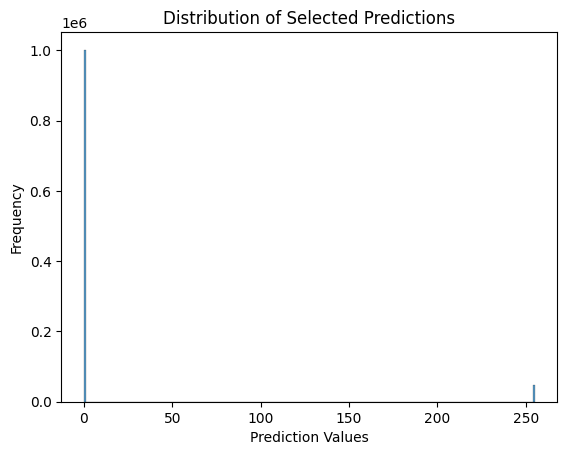

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

Accuracy in batch 0 during validation is: 0.9238


In [151]:
inference(val_loader, config)